In [1]:
import numpy as np
from model import *
from dataloader import *
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import pickle

In [2]:
config = {}
config['epochs'] = 20
config['temperature'] = 0.7
config['num_neurons'] = 100
config['num_layers'] = 1
config['input_dim'] = None
config['learning_rate'] = 0.001
config['saved_path'] = 'Saved_weights_baseline.pth'
config['validation_loss_path'] = 'val_loss_baseline.out' 
config['training_loss_path'] = 'training_loss_baseline.out' 
config['early_stop_epoch'] = 3
config['early_stopping'] = False
config['max_song_length'] = 1000

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [4]:
train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


if not os.path.exists('one_hot_decode.pkl') or not os.path.exists('one_hot_encode.pkl'):  
    print('creating new')
    all_characters = train_file.read()
    unique_characters = list(set(all_characters))

    print((unique_characters))


    #create one hot encodings for each unique character in the alphabet of the training data
    one_hot_dict_encode = {}
    one_hot_dict_decode = {}
    index = 0
    for unique_character in unique_characters:
        current_encoding = np.zeros(config['input_dim'])
        current_encoding[index] = 1

        one_hot_dict_encode[unique_character] = current_encoding
        one_hot_dict_decode[tuple(current_encoding)] = unique_character

        index += 1


    #start token
    current_encoding = np.zeros(config['input_dim'])
    current_encoding[93] = 1

    one_hot_dict_encode['$'] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = '$'

    #end song token
    current_encoding = np.zeros(config['input_dim'])
    current_encoding[94] = 1

    one_hot_dict_encode['%'] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = '%'
    
    f = open("one_hot_decode.pkl","wb")
    pickle.dump(one_hot_dict_decode, f)
    f.close()
    
    f = open("one_hot_encode.pkl", "wb")
    pickle.dump(one_hot_dict_encode, f)
    f.close()
else : 
    print('read in saved')
    f = open("one_hot_decode.pkl","rb")
    one_hot_dict_decode = pickle.load(f)
    f.close()
    
    f = open("one_hot_encode.pkl", "rb")
    one_hot_dict_encode = pickle.load(f)
    f.close()
    
config['input_dim'] = len(one_hot_dict_decode)

print(one_hot_dict_encode.keys())

train_file = open('train.txt', 'r')
train_songs = []

val_file = open('val.txt', 'r')
val_songs = []

test_file = open('test.txt', 'r')
test_songs = []


#split the songs into their own strings, while including start and end tags
song = []
for line in train_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            train_songs.append(song)
            song = []
    
song = []
for line in val_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            val_songs.append(song)
            song = []

song = []
for line in test_file:
    for character in line:
        song.append(one_hot_dict_encode[character])

        if character == '%':
            song.append(one_hot_dict_encode['\n'])
            test_songs.append(song)
            song = []   
            
            
len(one_hot_dict_decode)



read in saved
dict_keys(['4', 'A', '<', 't', '\t', '8', 'v', 'b', '@', '!', '^', 'K', ')', '9', 'o', 'z', 'y', 'V', 'Q', '3', 'u', '0', 'c', '\\', 'r', 'U', '+', 'p', ':', 'L', 'T', '6', '_', 'm', 'N', 'w', 'D', '>', 'i', ' ', '}', ',', 'X', 'g', 'I', 'k', 'a', '{', 'O', 'E', '*', 'x', '-', 'q', 'J', '1', '/', 'P', '.', 'Z', '7', 'd', '$', 'h', 'C', 'M', '~', 'n', '#', '?', '"', '\n', ']', '|', '&', 'F', "'", '[', 'W', 's', 'S', 'B', '2', 'e', 'G', 'j', 'l', '5', '=', 'f', 'H', 'R', 'Y', '(', '%'])


95

In [64]:
a = np.zeros(config['input_dim'])
a[73] = 1
print(one_hot_dict_decode[tuple(a)])

|


In [44]:
model = Lstm(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)

    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

if not os.path.exists(config['saved_path']):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.array([0,0]))
    np.savetxt(config['validation_loss_path'], np.array([0,0]))
    
model, optimizer


(Lstm(
   (lstm_layer): LSTM(95, 100, dropout=0.2)
   (fc): Linear(in_features=100, out_features=95, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [76]:
#for early stopping
num_times_incraesed = 0
prev_val_loss = float("inf")


#restore the model's weights 
checkpoint = torch.load(config['saved_path'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch in range(config['epochs']):
    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    
    total_loss = 0

    #for early stopping
    old_net_weights = model.state_dict()
    old_optimizer = optimizer.state_dict()
    
    #metrics for train and val loss
    training_losses = np.genfromtxt(config['training_loss_path'])
    validation_losses = np.genfromtxt(config['validation_loss_path'])

    #Shuffle the songs 
    random.shuffle(train_songs)
    
    #train
    model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        cell_state = cell_state.float()
        hidden = (hidden_state, cell_state)

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = song
        
        song_loss = 0
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
           
            
            
            if len(chunk) == 0:
                break
            
            #to computing device
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            #forward
            output, hidden = model(chunk, hidden)
            

            
            #loss
            targets = targets.argmax(dim=1)
            loss = criterion(output, targets)
            song_loss += loss
            
            #backprop
            loss.backward(retain_graph=True)
            optimizer.step()
            
        total_loss += song_loss/num_minibatches
      
    #calculate training loss
    average_epoch_loss = total_loss/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with train error '+ str(average_epoch_loss.cpu().item()))


        

    total_loss = 0
    #validation
    model.eval()
    with torch.no_grad():
        for song in val_songs:
            song_loss = 0
            
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            hidden_state = hidden_state.float()
            cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            cell_state = cell_state.float()
            hidden = (hidden_state, cell_state)


            #encode the characters to their respective one hot encoding
            encoded_inputs = song


            #val
            num_minibatches = math.ceil(len(encoded_inputs)/100)
            for i in range(num_minibatches):

                chunk, targets = MyDataset(encoded_inputs)[i]
                

                if len(chunk) == 0:
                    break

                #to computing device
                chunk = chunk.to(computing_device)
                targets = targets.to(computing_device)

                #forward
                output, hidden = model(chunk, hidden)

                targets = targets.argmax(dim=1)
                
#                 print('hi')
#                 print(output.squeeze().argmax(dim=1))

#                 print('mom')
#                 print(targets)
                loss = criterion(output, targets)
                song_loss += loss
                
            total_loss += song_loss/num_minibatches

                
    #calculate training loss
    average_val_epoch_loss = total_loss/len(val_songs)
    print('epoch ' + str(epoch + 1) + ' with val error '+ str(average_val_epoch_loss.cpu().item()))
    
    
    if config['early_stopping']:
        #early stopping
        if average_val_epoch_loss > prev_val_loss:
            print('keeping old weights')
            num_times_incraesed += 1
            model.load_state_dict(old_net_weights)
            optimizer.load_state_dict(old_optimizer)
        else : 
            print('val is less than previous')
            num_times_incraesed = 0
            prev_val_loss = average_val_epoch_loss

        if num_times_incraesed >= config['early_stop_epoch']:
            print('early stopping triggered')
            break       
            
            
    #save model and loss
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.append(training_losses, average_epoch_loss.cpu().item()))
    np.savetxt(config['validation_loss_path'], np.append(validation_losses, average_val_epoch_loss.cpu().item()))
        

EPPPPOCCCHHHHH 1
epoch 1 with train error 1.0933928489685059
epoch 1 with val error 1.6117006540298462
EPPPPOCCCHHHHH 2
epoch 2 with train error 1.0845848321914673
epoch 2 with val error 1.6113781929016113
EPPPPOCCCHHHHH 3
epoch 3 with train error 1.073896884918213
epoch 3 with val error 1.6332435607910156
EPPPPOCCCHHHHH 4
epoch 4 with train error 1.0691072940826416
epoch 4 with val error 1.607514500617981
EPPPPOCCCHHHHH 5
epoch 5 with train error 1.05618417263031
epoch 5 with val error 1.6394963264465332
EPPPPOCCCHHHHH 6
epoch 6 with train error 1.0503875017166138
epoch 6 with val error 1.6211785078048706
EPPPPOCCCHHHHH 7
epoch 7 with train error 1.0453078746795654
epoch 7 with val error 1.6021947860717773
EPPPPOCCCHHHHH 8
epoch 8 with train error 1.0355521440505981
epoch 8 with val error 1.6222515106201172
EPPPPOCCCHHHHH 9


KeyboardInterrupt: 

In [5]:
rnn_model = RNN(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)

    
rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=config['learning_rate'])

if not os.path.exists(config['saved_path'] + '_rnn'):
    torch.save({
        'model_state_dict': rnn_model.state_dict(),
        'optimizer_state_dict': rnn_optimizer.state_dict(),
    }, config['saved_path']  + '_rnn')
    
    np.savetxt(config['training_loss_path'] + '_rnn', np.array([0,0]))
    np.savetxt(config['validation_loss_path'] + '_rnn', np.array([0,0]))
    
rnn_model, rnn_optimizer

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(RNN(
   (rnn): RNN(95, 100, dropout=0.2)
   (fc): Linear(in_features=100, out_features=95, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [8]:
#for early stopping
num_times_incraesed = 0
prev_val_loss = float("inf")


#restore the model's weights 
checkpoint = torch.load(config['saved_path'] + '_rnn')
rnn_model.load_state_dict(checkpoint['model_state_dict'])
rnn_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch in range(config['epochs']):
    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    
    total_loss = 0

    #for early stopping
    old_net_weights = rnn_model.state_dict()
    old_optimizer = rnn_optimizer.state_dict()
    
    #metrics for train and val loss
    training_losses = np.genfromtxt(config['training_loss_path'] + '_rnn')
    validation_losses = np.genfromtxt(config['validation_loss_path'] + '_rnn')

    #Shuffle the songs 
    random.shuffle(train_songs)
    
    #train
    rnn_model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        hidden = hidden_state

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = song
        
        song_loss = 0
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            rnn_model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
           
            
            
            if len(chunk) == 0:
                break
            
            #to computing device
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            #forward
            output, hidden = rnn_model(chunk, hidden)
            

            
            #loss
            targets = targets.argmax(dim=1)
            loss = rnn_criterion(output, targets)
            song_loss += loss
            
            #backprop
            loss.backward(retain_graph=True)
            rnn_optimizer.step()
            
        total_loss += song_loss/num_minibatches
      
    #calculate training loss
    average_epoch_loss = total_loss/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with train error '+ str(average_epoch_loss.cpu().item()))


        

    total_loss = 0
    #validation
    rnn_model.eval()
    with torch.no_grad():
        for song in val_songs:
            song_loss = 0
            
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
            hidden_state = hidden_state.float()
            hidden = hidden_state


            #encode the characters to their respective one hot encoding
            encoded_inputs = song


            #val
            num_minibatches = math.ceil(len(encoded_inputs)/100)
            for i in range(num_minibatches):

                chunk, targets = MyDataset(encoded_inputs)[i]
                

                if len(chunk) == 0:
                    break

                #to computing device
                chunk = chunk.to(computing_device)
                targets = targets.to(computing_device)

                #forward
                output, hidden = rnn_model(chunk, hidden)

                targets = targets.argmax(dim=1)
                
#                 print('hi')
#                 print(output.squeeze().argmax(dim=1))

#                 print('mom')
#                 print(targets)
                loss = rnn_criterion(output, targets)
                song_loss += loss
                
            total_loss += song_loss/num_minibatches

                
    #calculate training loss
    average_val_epoch_loss = total_loss/len(val_songs)
    print('epoch ' + str(epoch + 1) + ' with val error '+ str(average_val_epoch_loss.cpu().item()))
    
    
    if config['early_stopping']:
        #early stopping
        if average_val_epoch_loss > prev_val_loss:
            print('keeping old weights')
            num_times_incraesed += 1
            rnn_model.load_state_dict(old_net_weights)
            rnn_optimizer.load_state_dict(old_optimizer)
        else : 
            print('val is less than previous')
            num_times_incraesed = 0
            prev_val_loss = average_val_epoch_loss

        if num_times_incraesed >= config['early_stop_epoch']:
            print('early stopping triggered')
            break       
            
            
    #save model and loss
    torch.save({
        'model_state_dict': rnn_model.state_dict(),
        'optimizer_state_dict': rnn_optimizer.state_dict(),
    }, config['saved_path'] + '_rnn')
    
    np.savetxt(config['training_loss_path'] + '_rnn', np.append(training_losses, average_epoch_loss.cpu().item()))
    np.savetxt(config['validation_loss_path'] + '_rnn', np.append(validation_losses, average_val_epoch_loss.cpu().item()))

EPPPPOCCCHHHHH 1
epoch 1 with train error 2.553476095199585
epoch 1 with val error 2.4413230419158936
EPPPPOCCCHHHHH 2
epoch 2 with train error 1.9926903247833252
epoch 2 with val error 2.132091522216797
EPPPPOCCCHHHHH 3
epoch 3 with train error 1.852763295173645
epoch 3 with val error 2.049252510070801
EPPPPOCCCHHHHH 4
epoch 4 with train error 1.7767468690872192
epoch 4 with val error 1.9801504611968994
EPPPPOCCCHHHHH 5
epoch 5 with train error 1.7135109901428223
epoch 5 with val error 2.0715765953063965
EPPPPOCCCHHHHH 6
epoch 6 with train error 1.6840397119522095
epoch 6 with val error 1.9413748979568481
EPPPPOCCCHHHHH 7
epoch 7 with train error 1.6453713178634644
epoch 7 with val error 1.957262635231018
EPPPPOCCCHHHHH 8
epoch 8 with train error 1.6245723962783813
epoch 8 with val error 1.9191571474075317
EPPPPOCCCHHHHH 9
epoch 9 with train error 1.6055363416671753
epoch 9 with val error 1.8921295404434204
EPPPPOCCCHHHHH 10
epoch 10 with train error 1.588417410850525
epoch 10 with va

KeyboardInterrupt: 

[2.44132304 2.13209152 2.04925251 1.98015046 2.0715766  1.9413749
 1.95726264 1.91915715 1.89212954 1.97445297]


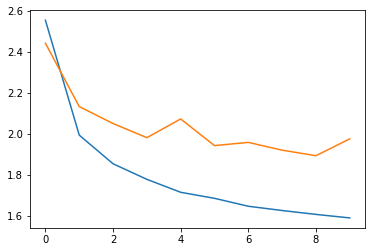

In [9]:
training_losses = np.genfromtxt(config['training_loss_path']+ '_rnn')[2:]
validation_losses = np.genfromtxt(config['validation_loss_path']+ '_rnn')[2:]
print(validation_losses)

x_axis = []
for i in range(len(training_losses)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_losses)
plt.plot(x_axis, validation_losses)

[2.2623105  1.93900692 1.86721361 1.73471773 1.70964777 1.67382395
 1.66307199 1.62063646 1.62720847 1.63149607 1.60833895 1.6112864
 1.5962069  1.58226824 1.59238398 1.61996806 1.59337294 1.61170065
 1.61137819 1.63324356 1.6075145  1.63949633 1.62117851 1.60219479
 1.62225151]


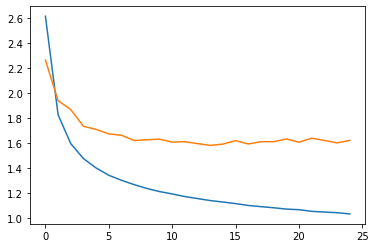

In [77]:
training_losses = np.genfromtxt(config['training_loss_path'])[2:]
validation_losses = np.genfromtxt(config['validation_loss_path'])[2:]
print(validation_losses)

x_axis = []
for i in range(len(training_losses)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_losses)
plt.plot(x_axis, validation_losses)

Temperature 0.7 seems to work the best

In [80]:
#get first initial input
output = torch.from_numpy(np.array(one_hot_dict_encode['X'])).float()[None,None,:].to(computing_device) 
                
#init hidden state
hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
hidden_state = hidden_state.float()
cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
cell_state = cell_state.float()
hidden = (hidden_state, cell_state)


new_song = []

#generate music
model.eval()
with torch.no_grad():
    while output.squeeze().argmax().item() != 94 : 
        output, hidden = model(output, hidden)
        
        softmax = F.softmax(output/config['temperature'])
        
        start = 0
        partitions = []
        
        for i in softmax[0]:
            partitions.append((start, start + i.item()))
            start = start + i.item()
        
        roll = random.uniform(0, partitions[-1][1])
        
        
        guess = 0
        for partition in partitions:
            if roll >= partition[0] and roll < partition[1]:
                break
            else : 
                guess += 1
        

        next_input = np.zeros(config['input_dim'])
        next_input[guess] = 1
        
        new_song.append(next_input)
        
        
        output = torch.from_numpy(next_input).float()[None, None, :].to(computing_device)
        

decoded_string = ""
for encoding in new_song:
#     print(one_hot_dict_decode[tuple(encoding)], end =" ")
    decoded_string += one_hot_dict_decode[tuple(encoding)]
print(decoded_string)
            
        
        
      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


:1
T:John McBway
O:France
A:Provence
R:Marche
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-26
Z:Pour toute observation mailto:galouvielle@free.fr
M:2/4
L:1/8
K:Gm
GA BG | G2 GB | c2 c2 | d2 d2 | d2 dd | d2 d2 | d2 d2 | d2 d2 | d2 cB |
A2 A2 | G2 GG | A2 A2 | A2 A2 | G3 :|
|: d | e2 e2 | d2 d2 | d2 dd | e2 ed | c2 A2 | B2 Bz | G2 G2 | G2 A2 | B2 B2 | c2 A2 | G2 E2 | G2 E2 |
A>B AG | A2 A2 | G4 | A4 | G>A B2 | G2 G2 | G2 G2 | G2 A2 | G2 G2 | A2 A2 | 
G2 GA | B2 A2 | G2 A2 | G4 ||
P:Intro
a | e2 de | d2 d2 | d2 d2 | d2 ed | c2 A2 | B2 c2 | B2 AG | A2 A2 | G2 AB | c2 c2 | A2 BA | G2 G2 :|
%
